In [9]:
import serial
import io
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style, rc
from ipywidgets import widgets
from functools import partial
from IPython.display import (
    Audio, clear_output, display, HTML
)
%matplotlib inline

In [7]:
print(serial.VERSION)

3.4


# Real-time Plotting of Streaming Data

Here, we are able to read in serial data (in our case, readings from a photoresistor), and plot our sensor readings in real-time. This takes care of the mismatch between the speed at which the writer is writing to the buffer and the speed at which the reader is reading from the buffer by building an intermediary buffer that guarantees that our plotter will be able to read and plot the most recently received reading correctly.

In [11]:
port = '/dev/ttyACM0'
baudrate = 9600
buf_size = 16

<IPython.core.display.Javascript object>


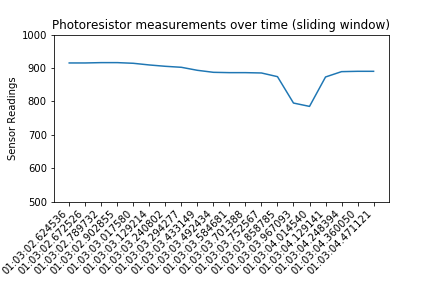

In [12]:
%matplotlib notebook
## Plot serial output with a sliding window
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs = []
ys = []
buf = ""
data = []

ser = serial.Serial(port, baudrate, timeout=1)

# build initial buffer
for _ in range(20):
    buf += ser.read(ser.in_waiting).decode()
    buf = buf[-buf_size:]

def animate(_, xs, ys, buf): 
    ser_input = ser.read(ser.in_waiting).decode()
    buf += ser_input
    buf = buf[-buf_size:]
    try:
        chunk = ser_input.split('\r')[-2]
        reading = float(chunk.strip())
        xs.append(datetime.datetime.now().strftime('%H:%M:%S.%f'))
        ys.append(reading)
        synth(reading)
        data.append(reading)
        ser.write(reading * 2)
    except:
        pass
    xs = xs[-20:]
    ys = ys[-20:]    
    ax.clear()
    ax.plot(xs, ys)
    ax.set(ylim=(500, 1000))
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('Photoresistor measurements over time (sliding window)')
    plt.ylabel('Sensor Readings')

anim = animation.FuncAnimation(
    fig, animate,
    fargs=(xs,ys,buf), interval=20,
)
plt.show()

In [165]:
ser.close()

# Transformations of Sensor Data

Here, we provide functions to allow users to perform a variety of post-processing and transformations of the sensor data we captured and plotted above. Some transformations we consider include: 
- interpreting each sensor reading as a frequency and playing a song that consists of each sensor reading played immediately after the beginning of the previous note.
- interpreting each sensor reading as a frequency and playing a song that consists of each sensor reading played consecutively. The user can choose to adjust various parameters, including:
    - the *duration* of each note. Defaults to 0.5s.
    - the *frequency* of each note; we will scale the sensor reading (frequency) by this is the value. Defaults to a factor of 1.
    - a *function* to apply to each sensor reading (frequency). Defaults to the identity function.

Users can additionally overlay these generated sounds to create an interesting mix of different sound waves.

In [86]:
rate = 16000.
duration = .5

In [87]:
def to_sound(f, duration=0.5, rate=16000, freq_scale=1):
    t = np.linspace(0., duration, int(rate * duration))
    return np.sin(f * 2. * np.pi * t * freq_scale)

In [88]:
def synth(f):
    x = to_sound(f)
    display(Audio(x, rate=rate, autoplay=True))

In [ ]:
# Notes played immediately one after the other
for i in data:
    synth(i)

In [85]:
flatten = lambda l: [item for sublist in l for item in sublist]
def nums_to_audio(
    data, 
    each_duration=duration, 
    freq_scale=1, 
    f=lambda x: x
):
    fp = flatten([to_sound(f(x), duration=each_duration, freq_scale=freq_scale) for x in data])
    display(Audio(fp, rate=rate, autoplay=True))

<IPython.core.display.Javascript object>


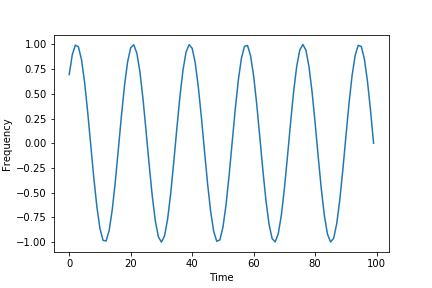

In [84]:
# duration = 0.5
wave = nums_to_audio(data,each_duration=0.5)
plt.plot(wave[-100:])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [90]:
# Longer duration
nums_to_audio(data,each_duration=1)

In [91]:
# Higher frequency
nums_to_audio(data,each_duration=0.5, freq_scale=2)

In [92]:
# Lower frequency
nums_to_audio(data,each_duration=0.5, freq_scale=0.5)

In [93]:
# Transformed by a function
nums_to_audio(data,each_duration=0.5, f=lambda x: x**2/1000)